# Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing, cluster, metrics, decomposition
from seaborn import pairplot, heatmap
import myModule as my
from kneed import KneeLocator

# Import du fichier principal

In [2]:
df = pd.read_csv('data/modified/df_final_2.csv')
df.head()

,code_iso_pays,pays,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_2017,pop_evolution_ratio,stabilite_politique,taux_droits_douane
0,41,"Chine, continentale",0.230721,0.087312,0.023313,0.999794,16659.000000,1.421022e+09,0.055742,-0.26,1.60
1,AFG,Afghanistan,0.095215,0.025641,0.508772,0.491228,2152.366489,3.629611e+07,0.339313,-2.75,4.94
2,AGO,Angola,0.089836,0.159624,0.911184,0.088816,6952.419362,2.981677e+07,0.426274,-0.32,9.48
3,ALB,Albanie,0.307760,0.056568,0.606061,0.393939,14230.989507,2.884169e+06,-0.049383,0.38,1.99
4,ARE,Émirats arabes unis,0.210715,0.213068,1.107143,0.111905,69957.618075,9.487203e+06,0.537924,0.74,11.79


In [3]:
df = df.set_index('pays')
df = df.drop(columns=["code_iso_pays","pop_2017"])

In [4]:
df.head()

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane
pays,,,,,,,,
"Chine, continentale",0.230721,0.087312,0.023313,0.999794,16659.000000,0.055742,-0.26,1.60
Afghanistan,0.095215,0.025641,0.508772,0.491228,2152.366489,0.339313,-2.75,4.94
Angola,0.089836,0.159624,0.911184,0.088816,6952.419362,0.426274,-0.32,9.48
Albanie,0.307760,0.056568,0.606061,0.393939,14230.989507,-0.049383,0.38,1.99
Émirats arabes unis,0.210715,0.213068,1.107143,0.111905,69957.618075,0.537924,0.74,11.79


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, Chine, continentale to Zimbabwe
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ratio_viandes        155 non-null    float64
 1   ratio_volailles      155 non-null    float64
 2   ratio_importee       155 non-null    float64
 3   ratio_produit        155 non-null    float64
 4   pib_par_habitant     155 non-null    float64
 5   pop_evolution_ratio  155 non-null    float64
 6   stabilite_politique  155 non-null    float64
 7   taux_droits_douane   155 non-null    float64
dtypes: float64(8)
memory usage: 10.9+ KB


In [6]:
df.describe()

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,0.189339,0.132757,0.504524,0.889903,22212.893690,0.153901,-0.054000,8.391290
std,0.098457,0.092883,0.564868,0.683085,22682.716828,0.149733,0.895973,11.527773
min,0.033557,0.006452,0.000000,0.000000,985.112041,-0.126900,-3.000000,0.000000
25%,0.107623,0.057447,0.043342,0.424982,5384.767769,0.047673,-0.605000,1.640000
50%,0.184959,0.105263,0.252964,0.938559,13635.448158,0.123808,0.030000,4.960000
75%,0.267709,0.196217,0.911237,1.049779,32428.580274,0.257000,0.720000,11.075000
max,0.452205,0.394525,2.715569,4.482759,132539.151376,0.755984,1.540000,80.100000


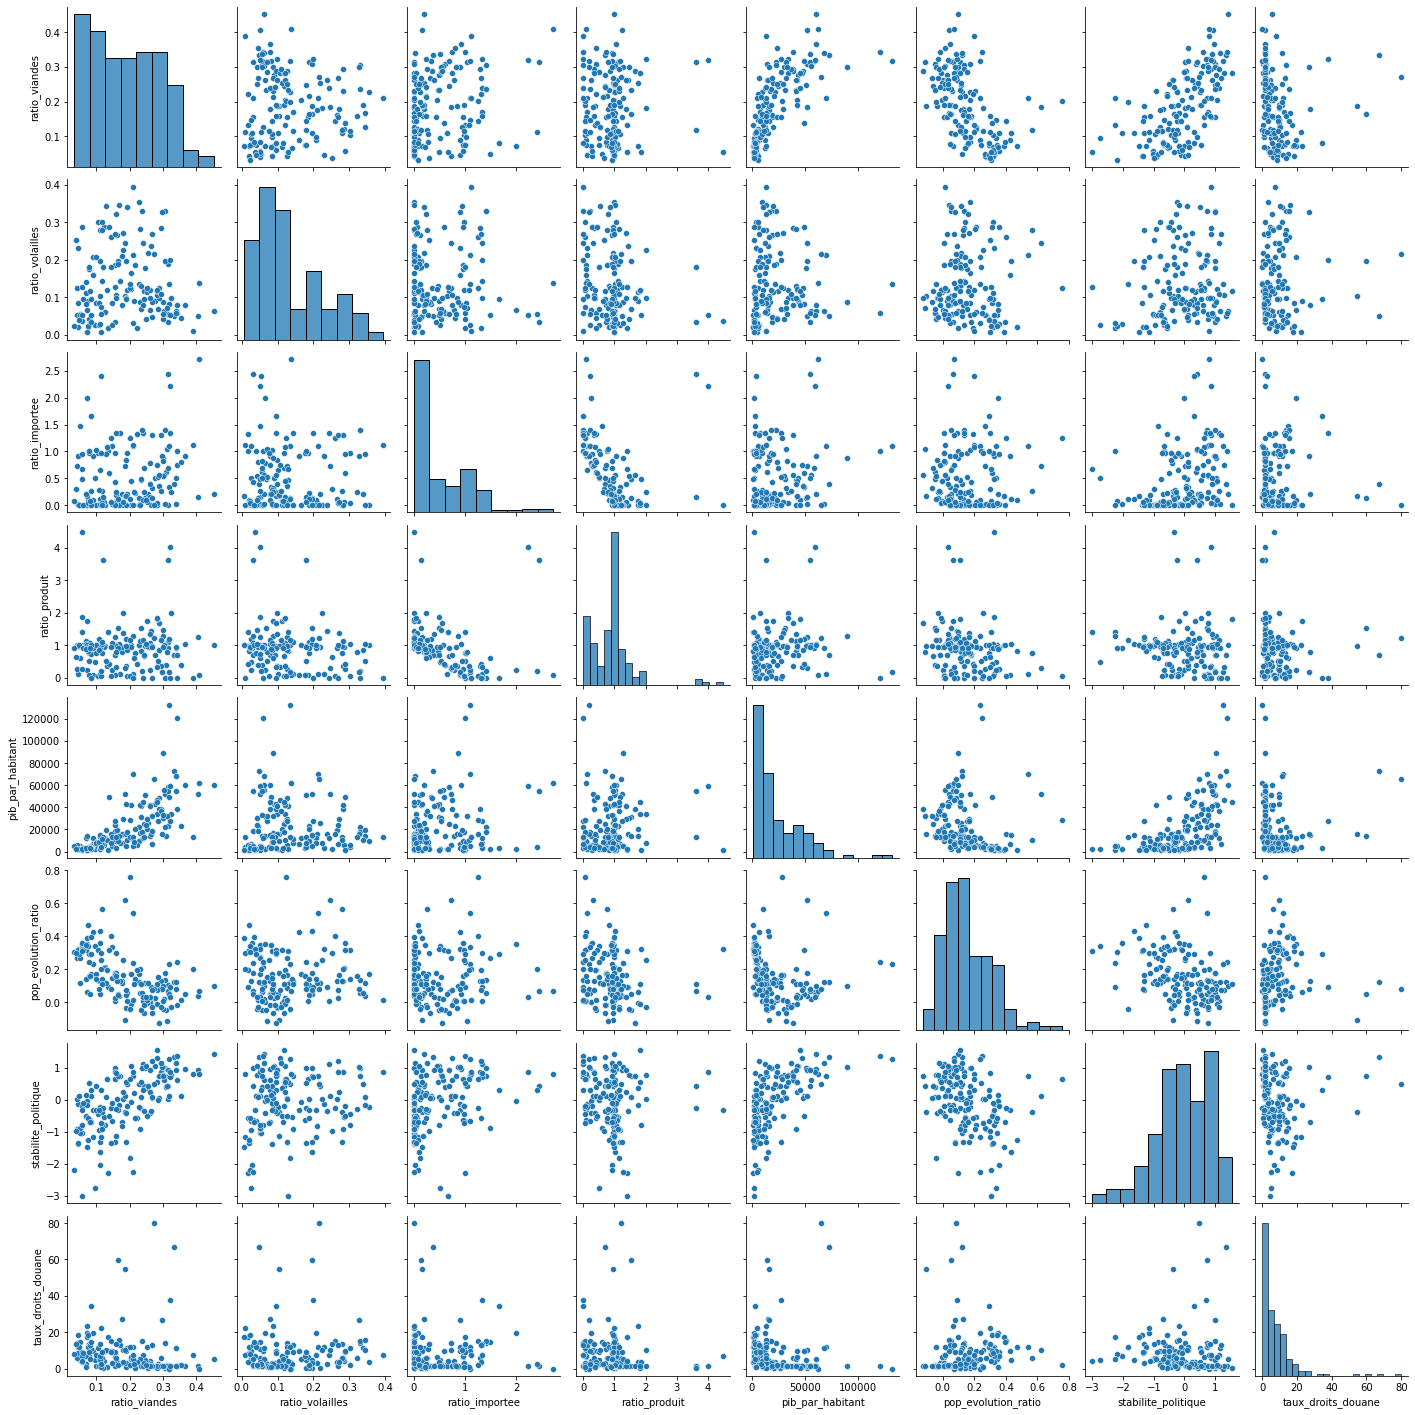

In [7]:
pairplot(df)

On trace un graphique de type pairplot pour essayer de dégager des tendances sur nos variables

In [8]:
matrice_corr_df = my.matrice_corr(df)

<AxesSubplot:>

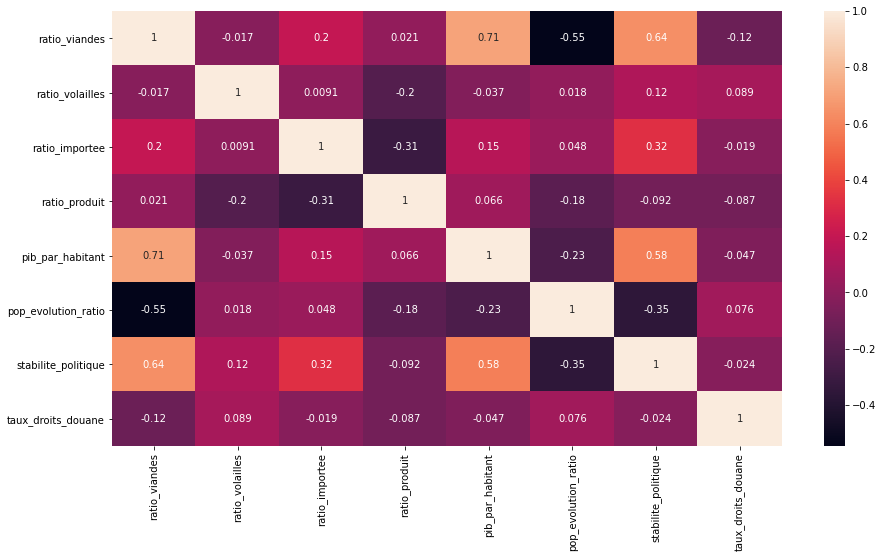

In [9]:
plt.figure(figsize = (15,8))
heatmap(matrice_corr_df, annot=True)

On observe une forte corrélation entre le ratio_viandes et le pib_par_habitant (0.71) ainsi qu'entre la stabilite_politique et le ratio_viandes (0.64)

# Classification ascendante hiérarchique

In [10]:
# Centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(df)
df_scaled = std_scale.transform(df)

In [11]:
#On crée un dataframe de nos données centrées réduites car on s'en servira pour afficher la heatmap des centroïds
df_s = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)
df_s.head()

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane
pays,,,,,,,,
"Chine, continentale",0.421666,-0.490847,-0.854660,0.161396,-0.245645,-0.657683,-0.230663,-0.591034
Afghanistan,-0.959085,-1.156965,0.007545,-0.585530,-0.887264,1.242302,-3.018772,-0.300360
Angola,-1.013899,0.290200,0.722255,-1.176551,-0.674961,1.824950,-0.297846,0.094748
Albanie,1.206668,-0.822925,0.180336,-0.728418,-0.353034,-1.362040,0.485960,-0.557093
Émirats arabes unis,0.217818,0.867451,1.070290,-1.142640,2.111717,2.573028,0.889060,0.295784


In [12]:
df_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
df_scaled.mean(axis=0)

array([ 2.29207334e-17,  2.29207334e-16,  1.80500776e-16, -2.86509168e-17,
       -8.02225669e-17, -3.43811001e-17,  0.00000000e+00,  1.97691326e-16])

In [14]:
Z = linkage(df_scaled,method='ward',metric='euclidean')

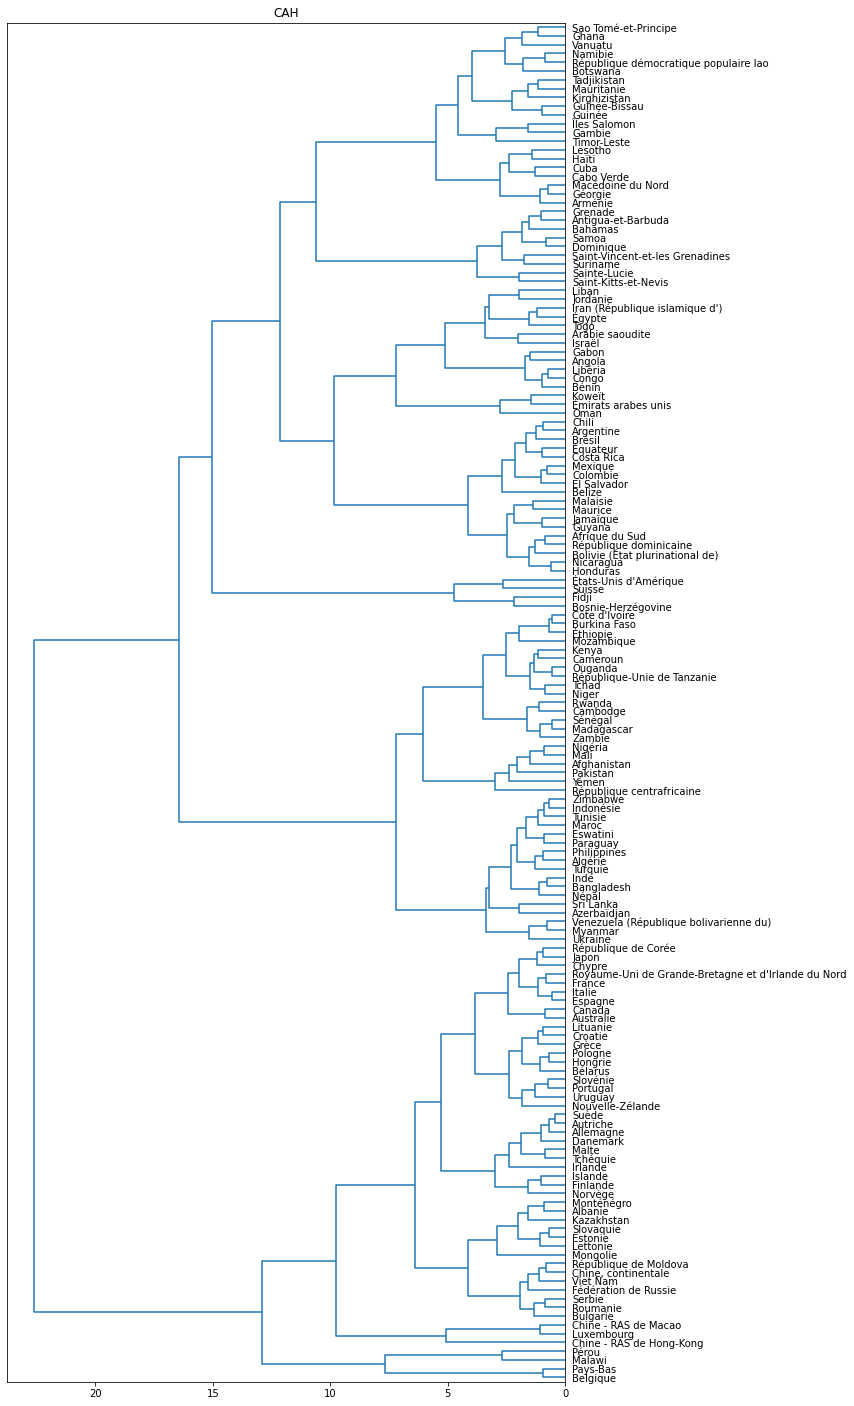

In [15]:
plt.figure(figsize=(10,25))
plt.title("CAH")
dendrogram(Z,labels=df.index,orientation='left',color_threshold=0,leaf_font_size=10)
plt.show()

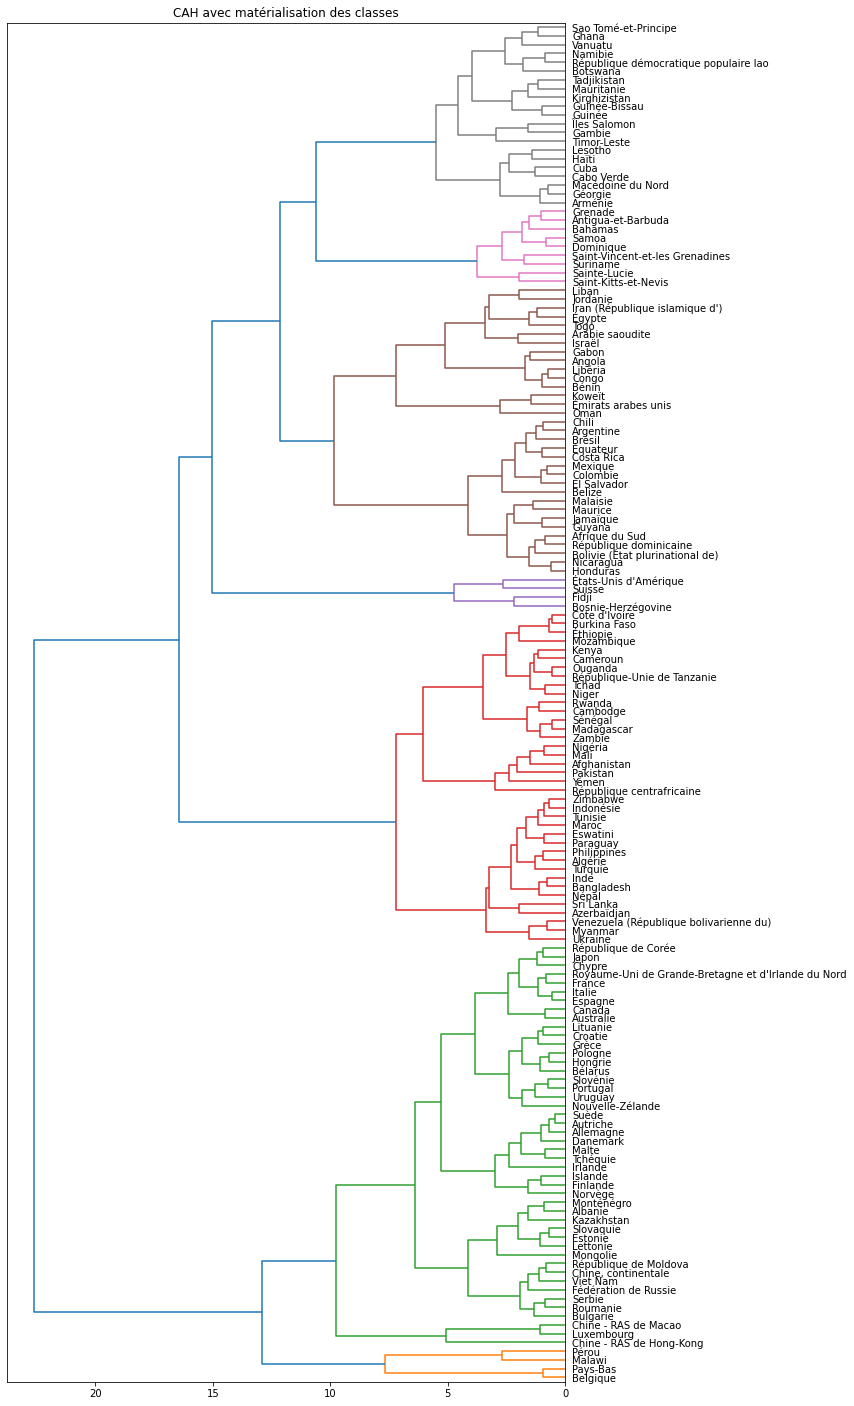

In [16]:
plt.figure(figsize=(10,25))
plt.title('CAH avec matérialisation des classes')
dendrogram(Z,labels=df.index,orientation='left',color_threshold=10,leaf_font_size=10)
plt.show()

In [17]:
groupes_cah = fcluster(Z,t=10,criterion='distance')
print(np.unique(groupes_cah).size, "groupes constitués")

7 groupes constitués


In [18]:
df["cah"] = groupes_cah
df.head()

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane,cah
pays,,,,,,,,,
"Chine, continentale",0.230721,0.087312,0.023313,0.999794,16659.000000,0.055742,-0.26,1.60,2
Afghanistan,0.095215,0.025641,0.508772,0.491228,2152.366489,0.339313,-2.75,4.94,3
Angola,0.089836,0.159624,0.911184,0.088816,6952.419362,0.426274,-0.32,9.48,5
Albanie,0.307760,0.056568,0.606061,0.393939,14230.989507,-0.049383,0.38,1.99,2
Émirats arabes unis,0.210715,0.213068,1.107143,0.111905,69957.618075,0.537924,0.74,11.79,5


In [19]:
df[df.index.get_level_values('pays') == 'France']

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane,cah
pays,,,,,,,,,
France,0.317754,0.080717,0.34143,1.180837,49377.126579,0.048058,0.11,1.64,2


On identifie les centroïdes de chaque cluster

In [20]:
df_cah_centroids = df.groupby(["cah"],as_index=False).agg({'mean'})
df_cah_centroids.head(10)

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane
,mean,mean,mean,mean,mean,mean,mean,mean
cah,,,,,,,,
1,0.202695,0.075135,1.203372,3.940206,32288.635545,0.133231,1.725000e-01,2.610000
2,0.293661,0.089033,0.482642,0.955081,43023.295224,0.041865,6.323913e-01,2.644783
3,0.097599,0.074734,0.119053,1.051729,6242.461632,0.223459,-1.040000e+00,9.534737
4,0.239066,0.140721,0.171333,1.103372,42126.050753,0.035847,5.425000e-01,65.275000
5,0.162468,0.245682,0.330514,0.789745,18386.402529,0.248096,-2.530303e-01,7.018182
6,0.255973,0.302134,1.228424,0.139793,19376.563622,0.077833,8.388889e-01,15.301111
7,0.128480,0.092940,1.143524,0.311497,7043.538019,0.184446,5.286776e-18,8.372381


Groupe 1: Pays consommateur de viandes, mais peu de volailles et qui en produit une très grande quantité par rapport à l'importation

Groupe 2: Groupe de la France : Pays riche et stable politiquement, qui consomme beaucoup de viande et de volailles, et qui en importe et en produit beaucoup. Le taux de douane très faible.  -> __le plus intéressant (1/7)__

Groupe 3: Pays très peuplé de l'asie de l'est et instable, qui ne consomme pas beaucoup de viandes ni de volailles et qui en importe très peu mais avec un faible taux de douane.

Groupe 4: Pays riche et stable politiquement, très consommateur de viande et de volailles, qui en importe beaucoup et en produit très peu. Taux de douane très élévé.

Groupe 5: Pays pauvre et instable politiquement, avec une forte croissance démographique. Il ne consomme pas beaucoup de viandes et importe très peu de volailles. Taux de douane faible.

Groupe 6: Pays stable politiquement, consommateur de viandes dont la volailles et qui en produit peu et en importe beaucoup. Taux de douane moyen __-> très intéressant__

Groupe 7: Pays moyennement stable politiquement, faible consommateur de viandes dont la volailles mais qui en importe plus qu’il n’en produit. Taux de douane relativement faible

## Heatmap des centroïds

In [21]:
df_s["cah"] = groupes_cah
df_s.head()

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane,cah
pays,,,,,,,,,
"Chine, continentale",0.421666,-0.490847,-0.854660,0.161396,-0.245645,-0.657683,-0.230663,-0.591034,2
Afghanistan,-0.959085,-1.156965,0.007545,-0.585530,-0.887264,1.242302,-3.018772,-0.300360,3
Angola,-1.013899,0.290200,0.722255,-1.176551,-0.674961,1.824950,-0.297846,0.094748,5
Albanie,1.206668,-0.822925,0.180336,-0.728418,-0.353034,-1.362040,0.485960,-0.557093,2
Émirats arabes unis,0.217818,0.867451,1.070290,-1.142640,2.111717,2.573028,0.889060,0.295784,5


In [22]:
df_s_cah_centroids = df_s.groupby(["cah"],as_index=False).agg({'mean'})
df_s_cah_centroids.head(10)

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane
,mean,mean,mean,mean,mean,mean,mean,mean
cah,,,,,,,,
1,0.136090,-0.622378,1.241200,4.479959,0.445643,-0.138493,0.253617,-0.503135
2,1.063005,-0.472266,-0.038863,0.095727,0.920430,-0.750659,0.768568,-0.500108
3,-0.934789,-0.626704,-0.684621,0.237673,-0.706362,0.466055,-1.104046,0.099512
4,0.506702,0.086026,-0.591768,0.313520,0.880746,-0.790981,0.667914,4.950488
5,-0.273802,1.219713,-0.309052,-0.147100,-0.169243,0.631128,-0.222859,-0.119499
6,0.678971,1.829462,1.285694,-1.101681,-0.125449,-0.509668,0.999788,0.601349
7,-0.620128,-0.430062,1.134906,-0.849501,-0.670931,0.204661,0.060465,-0.001646


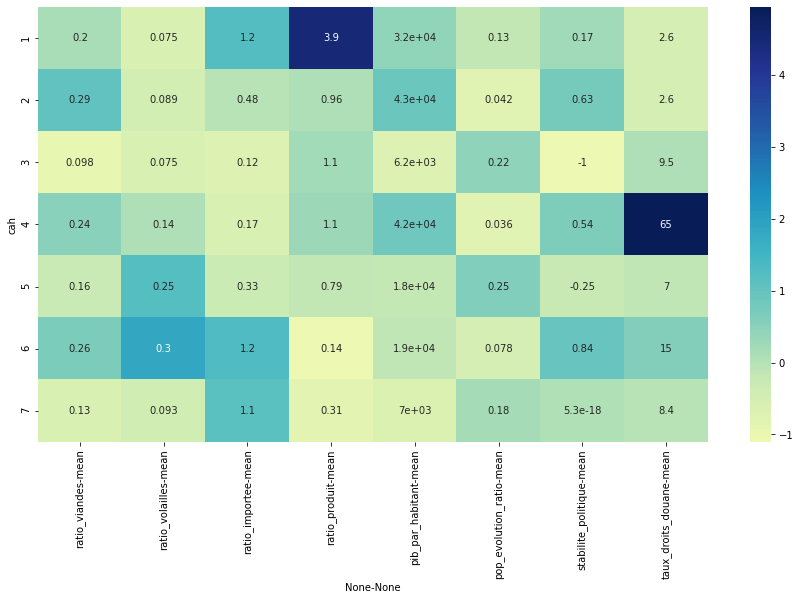

In [23]:
plt.figure(figsize = (15,8))
heatmap(df_s_cah_centroids, cmap="YlGnBu", center =1.5,annot=df_cah_centroids,annot_kws={'size':10})
plt.savefig('img/heatmap_cah.png')

# Algorithme du K-means

### Méthode du coude

In [24]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 16):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

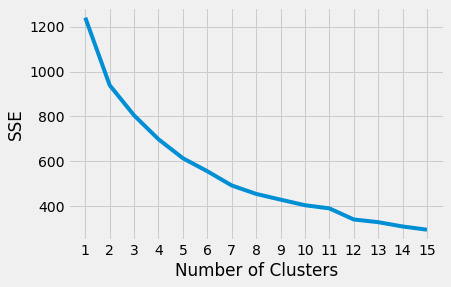

In [25]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 16), sse)
plt.xticks(range(1, 16))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [26]:
kl = KneeLocator(range(1, 16), sse, curve="convex", direction="decreasing")

print("Le nombre de cluster idéal selon la méthode du coude est de {}".format(kl.elbow))

Le nombre de cluster idéal selon la méthode du coude est de 5


### Coefficient de silhouette

In [27]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 16):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    score = metrics.silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

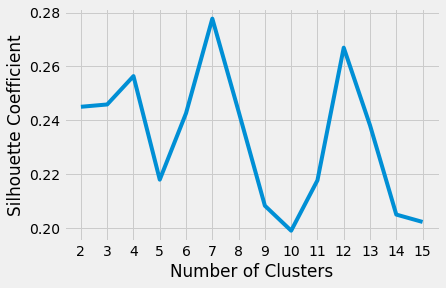

In [28]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 16), silhouette_coefficients)
plt.xticks(range(2, 16))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [29]:
cls = cluster.KMeans(init='random', n_clusters=7, n_init=10, max_iter =300, random_state = 42)
cls.fit(df_scaled)

KMeans(init='random', n_clusters=7, random_state=42)

In [30]:
#On ajoute la variable au dataframe initial
df['Kmeans'] = cls.labels_

In [31]:
for i in range(0,7):
    print("Groupe {}:".format(i))
    print(", ".join(df[df["Kmeans"]==i].index.get_level_values('pays').sort_values()))

Groupe 0:
Afrique du Sud, Arabie saoudite, Belize, Bolivie (État plurinational de), Brésil, Chili, Colombie, El Salvador, Guyana, Honduras, Iran (République islamique d'), Israël, Jamaïque, Jordanie, Malaisie, Maroc, Maurice, Mexique, Myanmar, Nicaragua, République dominicaine, Suriname, Togo, Venezuela (République bolivarienne du), Équateur
Groupe 1:
Angola, Bénin, Cabo Verde, Congo, Cuba, Gabon, Gambie, Ghana, Guinée, Guinée-Bissau, Haïti, Kirghizistan, Koweït, Lesotho, Libéria, Macédoine du Nord, Mauritanie, Namibie, Oman, République démocratique populaire lao, Sao Tomé-et-Principe, Tadjikistan, Timor-Leste, Vanuatu, Îles Salomon
Groupe 2:
Antigua-et-Barbuda, Bahamas, Chine - RAS de Hong-Kong, Chine - RAS de Macao, Dominique, Grenade, Luxembourg, Saint-Kitts-et-Nevis, Saint-Vincent-et-les Grenadines, Sainte-Lucie, Samoa, Émirats arabes unis
Groupe 3:
Afghanistan, Algérie, Azerbaïdjan, Bangladesh, Burkina Faso, Cambodge, Cameroun, Côte d'Ivoire, Eswatini, Inde, Indonésie, Kenya, Liba

On calcule les centroides

In [32]:
centroid_kmeans = df.drop(['cah'], axis=1).groupby('Kmeans').mean()
centroid_kmeans.head(10)

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane
Kmeans,,,,,,,,
0,0.165609,0.259539,0.139844,0.983852,15722.020642,0.158596,-0.365200,6.082800
1,0.116811,0.134559,1.157927,0.247682,8455.874371,0.277369,-0.028000,9.466400
2,0.287714,0.243189,1.335533,0.092171,45009.360241,0.139245,0.969167,11.748333
3,0.094006,0.071886,0.126072,1.047519,6598.474468,0.239406,-1.063243,9.905405
4,0.202695,0.075135,1.203372,3.940206,32288.635545,0.133231,0.172500,2.610000
5,0.239066,0.140721,0.171333,1.103372,42126.050753,0.035847,0.542500,65.275000
6,0.283108,0.089236,0.407646,0.981416,36596.594235,0.036462,0.548125,2.768750


__Groupe 0__ : Pays moyennement consommateur de viandes dont le poulet mais qui en produit beaucoup plus qu'il n'en importe. Ils ont un faible taux de douane.

__Groupe 1__ : Pays pauvres, peu consommateur de viandes dont la volaille, mais qui en importe beaucoup et en produit très peu avec un taux de douane moyen.

__Groupe 2__ : Pays riche et stable politiquement, très consommateur de viande et de volailles, qui en importe beaucoup et en produit très peu avec un taux de douane moyen __-> très intéressant__

__Groupe 3__ : Pays pauvres et très instable, très peu consommateur de viandes, qui en produit une très grande partie. 

__Groupe 4__ : Pays moyennement riche, très consommateur de viande mais très peu de poulet, et qui produit beaucoup plus qu'il n'importe

__Groupe 5__ : Pays riche et stable politiquement, consommateur moyen de viande dont le poulet, qui en importe très peu et en produit beaucoup et dont le taux de douane est très elevé.

__Groupe 6__ : Groupe de la France : Pays riche,très consommateur de viande et moyennement de poulet, qui en produit plus qu'il n'en importe et dont le taux de douane est très faible.

## Heatmap des centroïds

In [33]:
df_s['Kmeans'] = cls.labels_

In [34]:
df_s_kmeans_centroids = df_s.drop(['cah'], axis=1).groupby(["Kmeans"],as_index=False).agg({'mean'})
df_s_kmeans_centroids.head(10)

,ratio_viandes,ratio_volailles,ratio_importee,ratio_produit,pib_par_habitant,pop_evolution_ratio,stabilite_politique,taux_droits_douane
,mean,mean,mean,mean,mean,mean,mean,mean
Kmeans,,,,,,,,
0,-0.241794,1.369387,-0.647694,0.137982,-0.287087,0.031464,-0.348458,-0.200904
1,-0.739030,0.019464,1.160487,-0.943226,-0.608464,0.827265,0.029113,0.093565
2,1.002401,1.192792,1.475926,-1.171622,1.008273,-0.098193,1.145663,0.292157
3,-0.971399,-0.657466,-0.672154,0.231491,-0.690615,0.572902,-1.130072,0.131771
4,0.136090,-0.622378,1.241200,4.479959,0.445643,-0.138493,0.253617,-0.503135
5,0.506702,0.086026,-0.591768,0.313520,0.880746,-0.790981,0.667914,4.950488
6,0.955467,-0.470066,-0.172061,0.134406,0.636182,-0.786863,0.674213,-0.489320


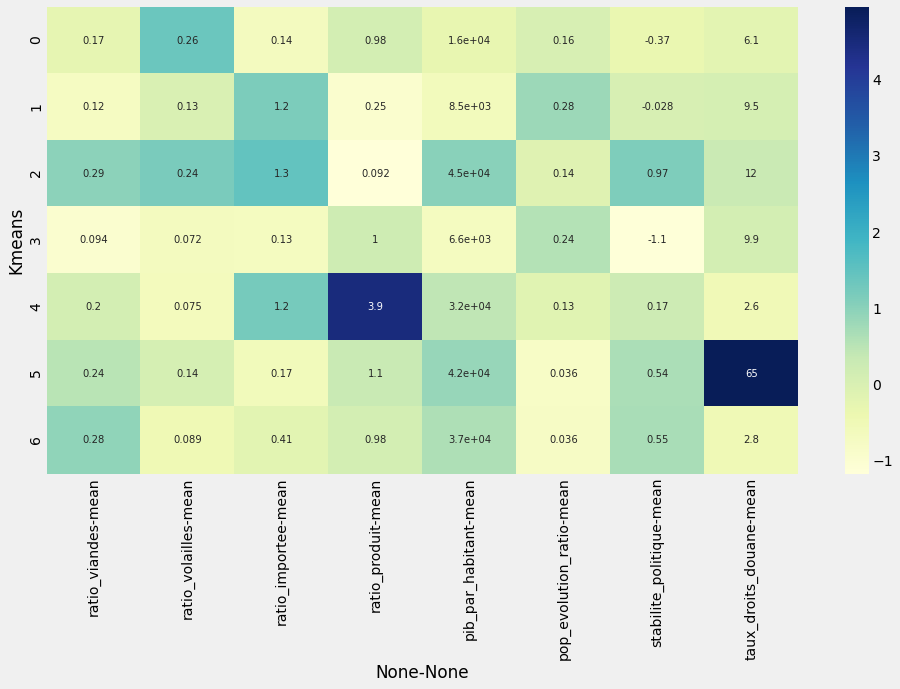

In [35]:
plt.figure(figsize = (15,8))
heatmap(df_s_kmeans_centroids, cmap="YlGnBu",annot=centroid_kmeans,annot_kws={'size':10})
plt.savefig('img/heatmap_kmeans.png')

# ACP

### Calcul des composantes principales

In [36]:
pca = decomposition.PCA(svd_solver='full')

In [37]:
coord = pca.fit_transform(df_scaled)
print(pca.n_components_)

8


In [38]:
n_comp = 8
kmeans_groups = df.Kmeans
cah_groups = df.cah

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(df_scaled)

PCA(n_components=8)

### Eboulis des valeurs propres

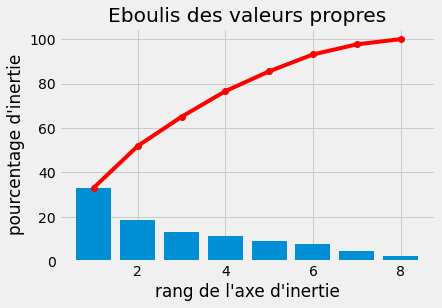

In [39]:
my.display_scree_plot(pca)

### Cercle des corrélations

In [40]:
n_comp=4

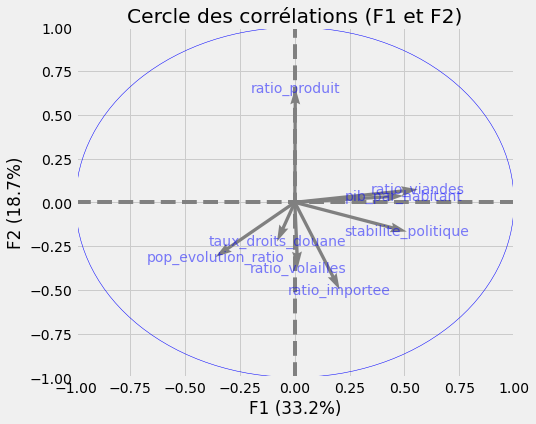

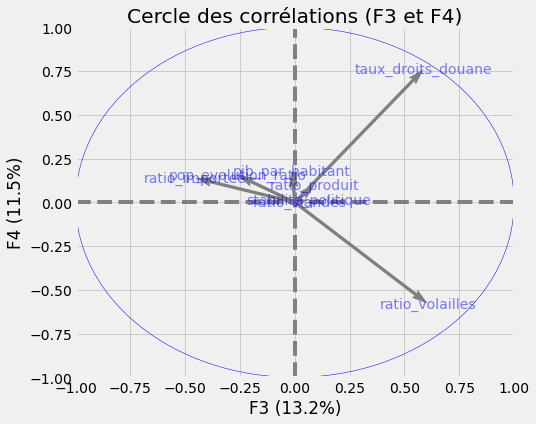

In [41]:
pcs = pca.components_
my.display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(df.columns))

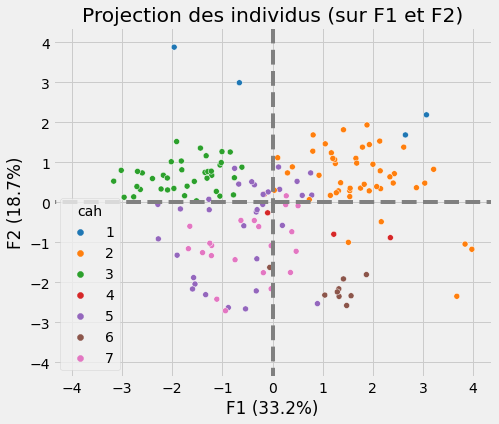

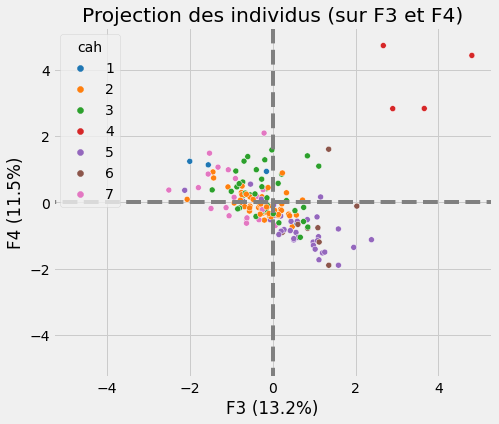

In [42]:
# Projection des individus
df_projected = pca.transform(df_scaled)
my.display_factorial_planes(df_projected, n_comp, pca, [(0,1),(2,3)],categories=df['cah'])
plt.show()

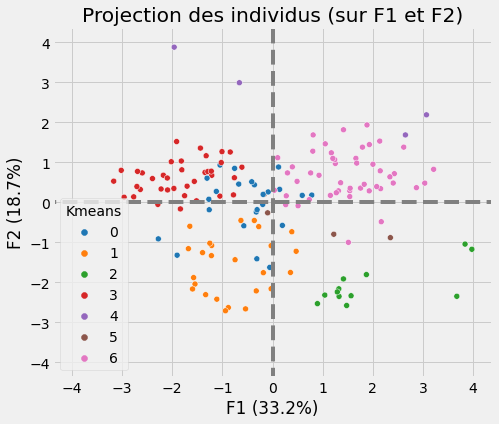

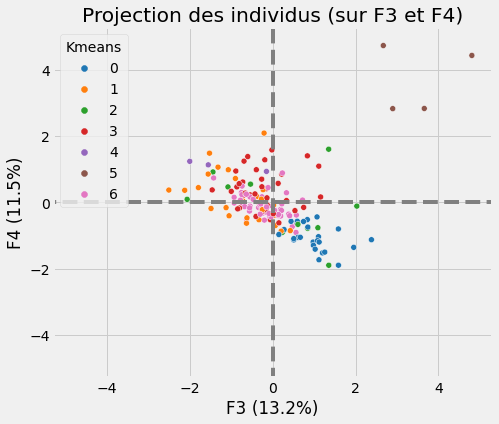

In [43]:
# Projection des individus
df_projected = pca.transform(df_scaled)
my.display_factorial_planes(df_projected, n_comp, pca, [(0,1),(2,3)],categories = df['Kmeans'])